In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import warnings
import tensorflow.keras as keras

In [58]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing.image import ImageDataGenerator

In [59]:
#CSV읽어오기

In [60]:
data_input = pd.read_csv('train_data.csv')
data_input.head()


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,5,640805896,L,5,68,0,0,0,0,0,255,21,1
1,2,5,940388076,R,1,68,0,0,0,255,0,255,21,0
2,2,5,1351088028,L,1,68,0,0,0,0,0,255,21,1
3,2,5,1633417959,R,5,68,0,0,0,255,0,255,21,0
4,1,25,1789648218,L,1,62,0,0,0,1,0,1,49,0


In [61]:
#img_path로 이미지 경로 추가하기

In [62]:
data_input['img_path'] = data_input.apply(lambda row: f"image/{row.patient_id}_{row.image_id}.png", axis=1)
data_input.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54622 entries, 0 to 54621
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   site_id                  54622 non-null  int64 
 1   patient_id               54622 non-null  int64 
 2   image_id                 54622 non-null  int64 
 3   laterality               54622 non-null  object
 4   view                     54622 non-null  int64 
 5   age                      54622 non-null  int64 
 6   cancer                   54622 non-null  int64 
 7   biopsy                   54622 non-null  int64 
 8   invasive                 54622 non-null  int64 
 9   BIRADS                   54622 non-null  int64 
 10  implant                  54622 non-null  int64 
 11  density                  54622 non-null  int64 
 12  machine_id               54622 non-null  int64 
 13  difficult_negative_case  54622 non-null  int64 
 14  img_path                 54622 non-nul

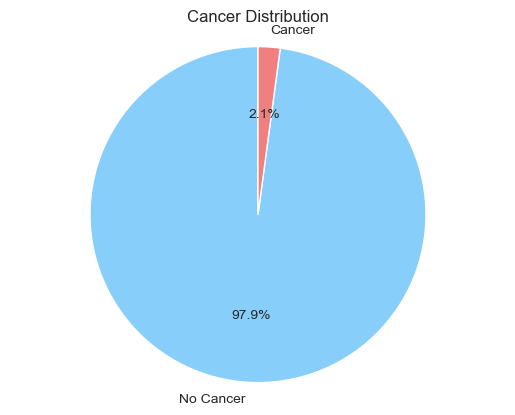

Cancer 0 count: 53466
Cancer 1 count: 1156


In [63]:
#암의 유무 수 카운트 

cancer_count = data_input['cancer'].value_counts()

# 그래프 그리기
labels = ['No Cancer', 'Cancer']
sizes = [cancer_count[0], cancer_count[1]]
colors = ['lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Cancer Distribution')
plt.show()

cancer_count = data_input['cancer'].value_counts()
zero_count = cancer_count[0]
one_count = cancer_count[1]

print("Cancer 0 count:", zero_count)
print("Cancer 1 count:", one_count)



<Axes: xlabel='cancer', ylabel='age'>

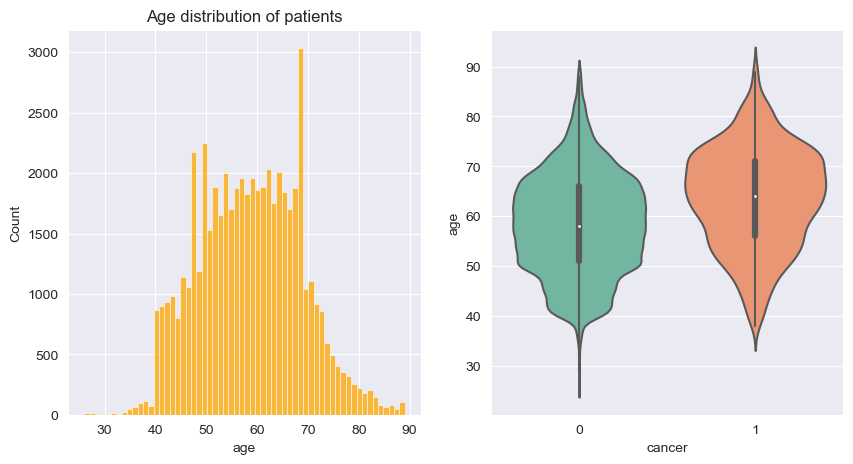

In [65]:
#나이 분포도와 나이별 암환자 분포도 조사 
sns.set_style('darkgrid')
sns.set_color_codes('bright')

warnings.filterwarnings("ignore", category=FutureWarning)

ages = data_input[data_input.age.isnull() == False].groupby(
    'patient_id').age.apply(lambda l: np.unique(l)[0])

fig, ax = plt.subplots(1,2,figsize=(10,5))

sns.histplot(data_input['age'], color='orange', bins=60, ax=ax[0])
ax[0].set_title('Age distribution of patients');
sns.violinplot(x=data_input['cancer'], y=data_input['age'], ax=ax[1], palette='Set2')


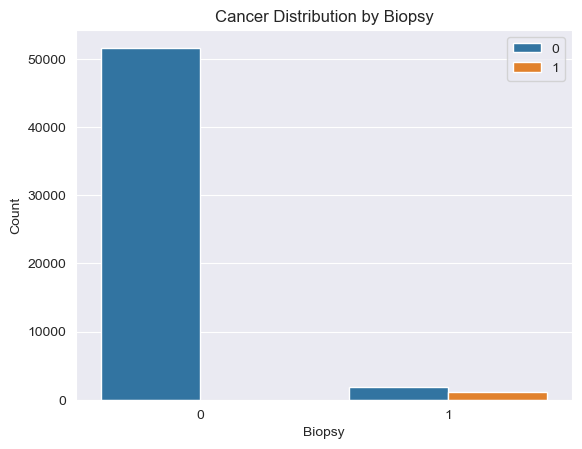

In [66]:
# biopsy와 cancer 간의 관계를 나타내는 데이터프레임 생성
biopsy_cancer_df = data_input.groupby(['biopsy', 'cancer']).size().reset_index(name='count')

# 막대그래프로 시각화
sns.barplot(data=biopsy_cancer_df, x='biopsy', y='count', hue='cancer')
plt.xlabel('Biopsy')
plt.ylabel('Count')
plt.title('Cancer Distribution by Biopsy')
plt.legend()
plt.show()


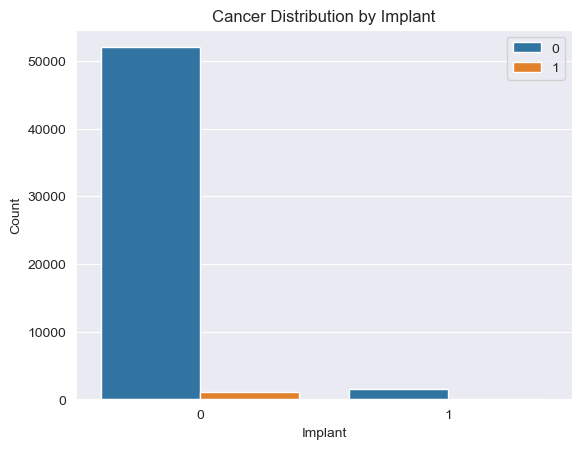

In [67]:
# implant와 cancer 간의 관계를 나타내는 데이터프레임 생성
implant_cancer_df = data_input.groupby(['implant', 'cancer']).size().reset_index(name='count')

# 막대그래프로 시각화
sns.barplot(data=implant_cancer_df, x='implant', y='count', hue='cancer')
plt.xlabel('Implant')
plt.ylabel('Count')
plt.title('Cancer Distribution by Implant')
plt.legend()
plt.show()


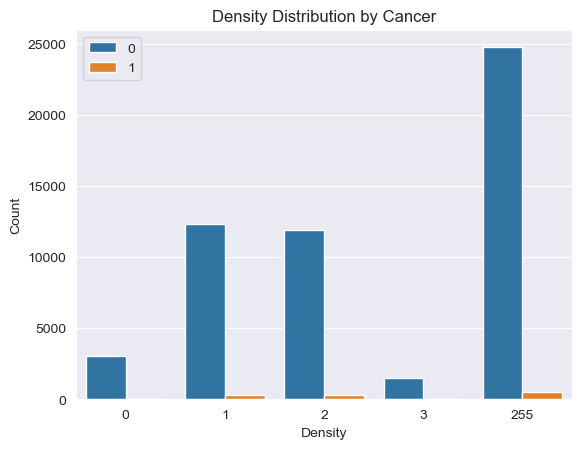

In [68]:
# density와 cancer 간의 관계를 나타내는 데이터프레임 생성
density_cancer_df = data_input.groupby(['density', 'cancer']).size().reset_index(name='count')

# 막대그래프로 시각화
sns.barplot(data=density_cancer_df, x='density', y='count', hue='cancer')
plt.xlabel('Density')
plt.ylabel('Count')
plt.title('Density Distribution by Cancer')
plt.legend()
plt.show()


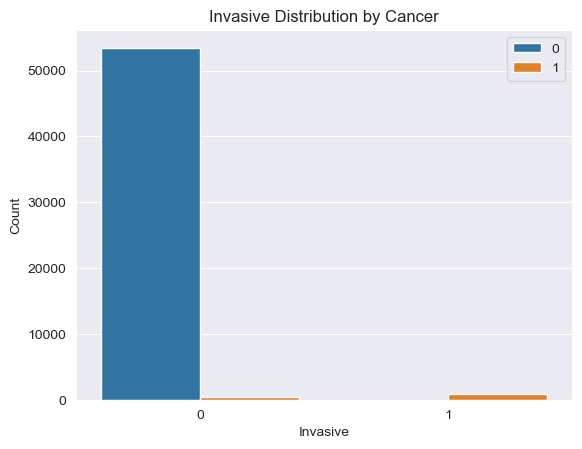

In [69]:
invasive_cancer_df = data_input.groupby(['invasive', 'cancer']).size().reset_index(name='count')

sns.barplot(data=invasive_cancer_df, x='invasive', y='count', hue='cancer')
plt.xlabel('Invasive')
plt.ylabel('Count')
plt.title('Invasive Distribution by Cancer')
plt.legend()
plt.show()

In [28]:
DF_train = data_input[data_input['biopsy']==1].reset_index(drop=True)
DF_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2963 entries, 0 to 2962
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   site_id                  2963 non-null   int64 
 1   patient_id               2963 non-null   int64 
 2   image_id                 2963 non-null   int64 
 3   laterality               2963 non-null   object
 4   view                     2963 non-null   int64 
 5   age                      2963 non-null   int64 
 6   cancer                   2963 non-null   int64 
 7   biopsy                   2963 non-null   int64 
 8   invasive                 2963 non-null   int64 
 9   BIRADS                   2963 non-null   int64 
 10  implant                  2963 non-null   int64 
 11  density                  2963 non-null   int64 
 12  machine_id               2963 non-null   int64 
 13  difficult_negative_case  2963 non-null   int64 
 14  img_path                 2963 non-null  

In [29]:
DF_train = DF_train.groupby(['cancer']).apply(lambda x: x.sample
                                             (1158,replace = True)
                                             ).reset_index(drop=True)

print('New Data Size:', DF_train.shape[0])
print(DF_train.value_counts())

New Data Size: 2316
site_id  patient_id  image_id    laterality  view  age  cancer  biopsy  invasive  BIRADS  implant  density  machine_id  difficult_negative_case  img_path                  
2        53727       2097422495  L           1     68   1       1       1         255     0        255      48          0                        image/53727_2097422495.png    6
1        41010       2042146023  L           5     59   1       1       1         0       0        3        49          0                        image/41010_2042146023.png    5
         10130       1672636630  L           5     71   1       1       1         0       0        1        49          0                        image/10130_1672636630.png    5
2        24240       277199142   L           1     57   1       1       1         255     0        255      29          0                        image/24240_277199142.png     5
1        6659        630551380   R           1     56   1       1       1         0       0        1

In [30]:
DF_train.loc[120,'img_path']

'image/46892_1821777780.png'

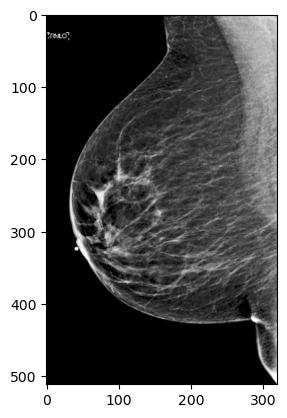

In [31]:
# a sample image
img = cv2.imread(DF_train.loc[120, 'img_path'])
plt.imshow(img, cmap = 'gray')


In [32]:
img.shape

(512, 320, 3)

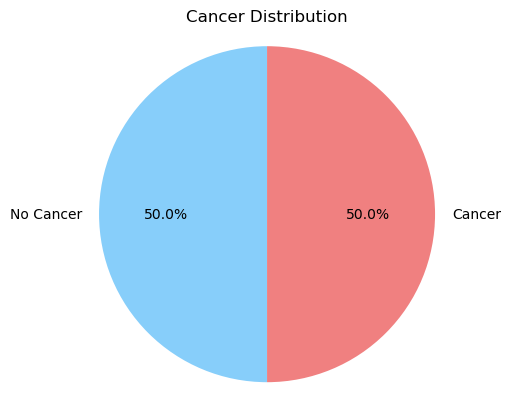

Cancer 0 count: 1158
Cancer 1 count: 1158


In [34]:
#암의 유무 수 카운트 

cancer_count = DF_train['cancer'].value_counts()

# 그래프 그리기
labels = ['No Cancer', 'Cancer']
sizes = [cancer_count[0], cancer_count[1]]
colors = ['lightskyblue', 'lightcoral']
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Cancer Distribution')
plt.show()

cancer_count = DF_train['cancer'].value_counts()
zero_count = cancer_count[0]
one_count = cancer_count[1]

print("Cancer 0 count:", zero_count)
print("Cancer 1 count:", one_count)



<Axes: xlabel='cancer', ylabel='age'>

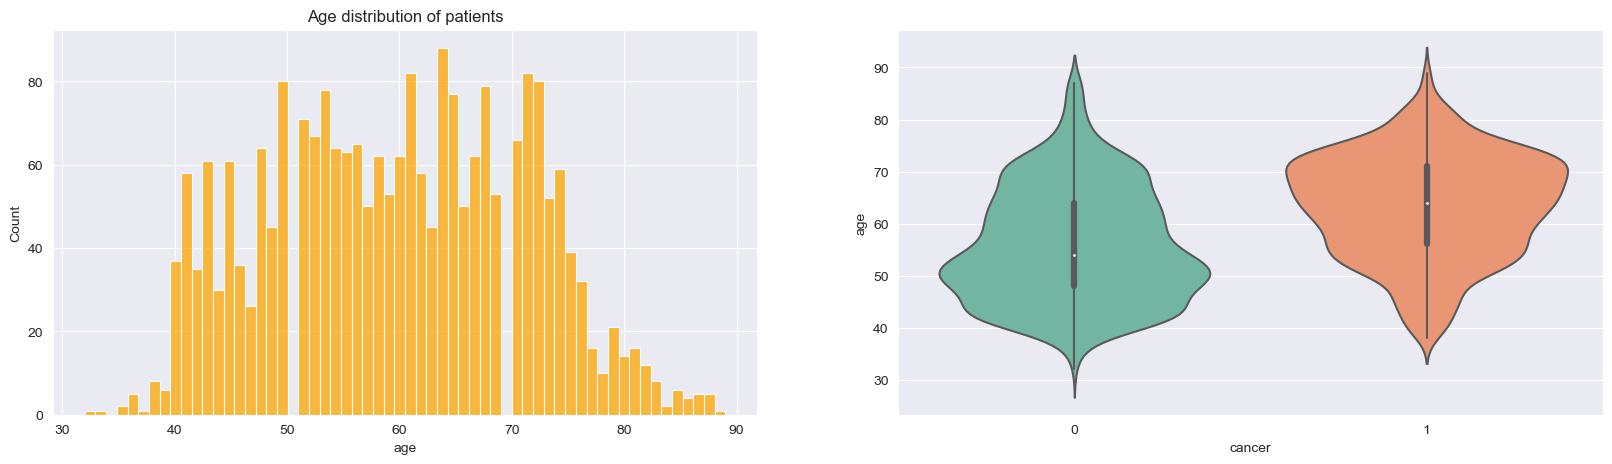

In [38]:
#나이 분포도와 나이별 암환자 분포도 조사 
sns.set_style('darkgrid')
sns.set_color_codes('bright')

warnings.filterwarnings("ignore", category=FutureWarning)

ages = DF_train[DF_train.age.isnull() == False].groupby(
    'patient_id').age.apply(lambda l: np.unique(l)[0])

fig, ax = plt.subplots(1,2,figsize=(20,5))

sns.histplot(DF_train['age'], color='orange', bins=60, ax=ax[0])
ax[0].set_title('Age distribution of patients');
sns.violinplot(x=DF_train['cancer'], y=DF_train['age'], ax=ax[1], palette='Set2')


<Axes: xlabel='density', ylabel='count'>

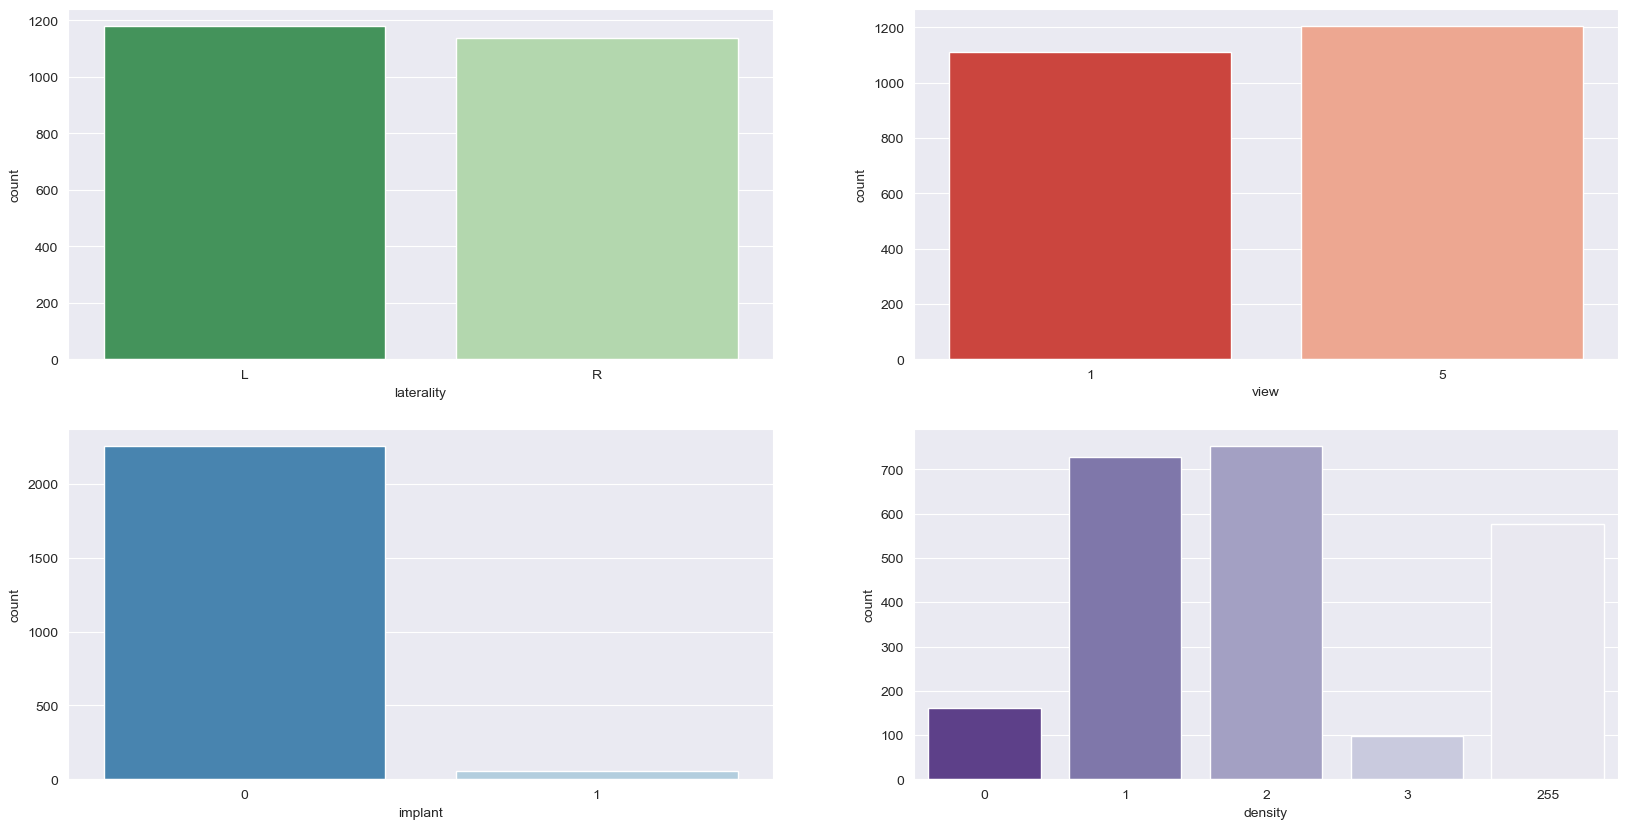

In [39]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.countplot(x=DF_train['laterality'], ax=ax[0, 0], palette='Greens_r')
sns.countplot(x=DF_train['view'], ax=ax[0, 1], palette='Reds_r')
sns.countplot(x=DF_train['implant'], ax=ax[1, 0], palette='Blues_r')
sns.countplot(x=DF_train['density'], ax=ax[1, 1], palette='Purples_r')


In [21]:
# 이러면 안된다 학습을 너무 무분별하게 한다 
# 따라서 나는 학습을 L,R로 나누고 view CC(1),MLO(5)를 기준으로 나눠서 학습
#L: [1, 0]
#R: [0, 1]
# CC: [1, 0]
# MLO: [0, 1]
#왼쪽 유방(L)의 크레니오카우달 뷰(CC) 이미지에 대한 벡터는 [1, 0, 1, 0]


In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import load_img, img_to_array
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, concatenate
from keras.optimizers import Adam

laterality_one_hot = pd.get_dummies(DF_train['laterality'], prefix='laterality')
view_one_hot = pd.get_dummies(DF_train['view'], prefix='view')

DF_train_encoded = pd.concat([DF_train, laterality_one_hot, view_one_hot], axis=1)

DF_train_encoded = DF_train_encoded.drop(['laterality', 'view'], axis=1)

#데이터 분할 열
structured_data = DF_train_encoded[['laterality_L', 'laterality_R', 'view_1', 'view_5']].values
target = DF_train_encoded['cancer'].values
image_paths = DF_train_encoded['img_path'].values

#데이터 분할
train_image_paths, test_image_paths, train_structured_data, test_structured_data, train_target, test_target = train_test_split(
    image_paths, structured_data, target, test_size=0.2, random_state=42)

#이미지 로드
def load_and_process_image(image_path):
    # Load image file
    image = load_img(image_path, target_size=(512, 320))  # resize the image to target size while loading
    # Convert the image to numpy array and normalize to [0,1]
    image = img_to_array(image) / 255.0
    return image

train_images = np.array([load_and_process_image(img_path) for img_path in train_image_paths])
test_images = np.array([load_and_process_image(img_path) for img_path in test_image_paths])

# Define the model
image_input = Input(shape=(512, 320, 3))
x = Conv2D(32, (3, 3), activation='relu')(image_input)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

structured_input = Input(shape=(4,))
y = Dense(16, activation='relu')(structured_input)
y = Dropout(0.5)(y)

combined = concatenate([x, y])
z = Dense(64, activation='relu')(combined)
z = Dropout(0.5)(z)
z = Dense(32, activation='relu')(z)
z = Dropout(0.5)(z)
output = Dense(1, activation='sigmoid')(z)

model = Model(inputs=[image_input, structured_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

#모델 학습
history = model.fit([train_images, train_structured_data], train_target, validation_split=0.2, epochs=10, batch_size=32)

#test정확도
test_loss, test_acc = model.evaluate([test_images, test_structured_data], test_target)
print("Test accuracy:", test_acc)


Epoch 1/10
47/47 [==============================] - 182s 4s/step - loss: 0.9819 - accuracy: 0.5091 - val_loss: 0.6925 - val_accuracy: 0.5121
Epoch 2/10
47/47 [==============================] - 190s 4s/step - loss: 0.6951 - accuracy: 0.5658 - val_loss: 0.6882 - val_accuracy: 0.5903
Epoch 3/10
47/47 [==============================] - 194s 4s/step - loss: 0.6698 - accuracy: 0.5942 - val_loss: 0.6581 - val_accuracy: 0.6819
Epoch 4/10
47/47 [==============================] - 184s 4s/step - loss: 0.6256 - accuracy: 0.6543 - val_loss: 0.6179 - val_accuracy: 0.7305
Epoch 5/10
47/47 [==============================] - 183s 4s/step - loss: 0.5574 - accuracy: 0.7245 - val_loss: 0.5173 - val_accuracy: 0.7305
Epoch 6/10
47/47 [==============================] - 181s 4s/step - loss: 0.4936 - accuracy: 0.7657 - val_loss: 0.4895 - val_accuracy: 0.7736
Epoch 7/10
47/47 [==============================] - 178s 4s/step - loss: 0.3874 - accuracy: 0.8285 - val_loss: 0.4380 - val_accuracy: 0.8059
Epoch 8/10
47

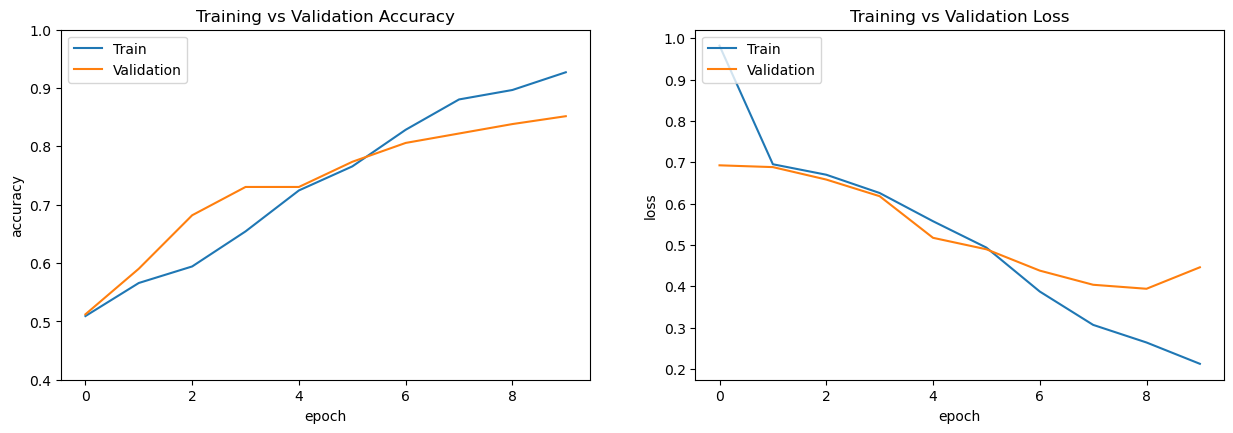

In [17]:
# 학습/검증 정확도 및 손실 값보기
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize = (15,10))

# 훈련/ 검증 정확도
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')

# 훈련 /검증 loss
plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()


15/15 [==============================] - 8s 491ms/step


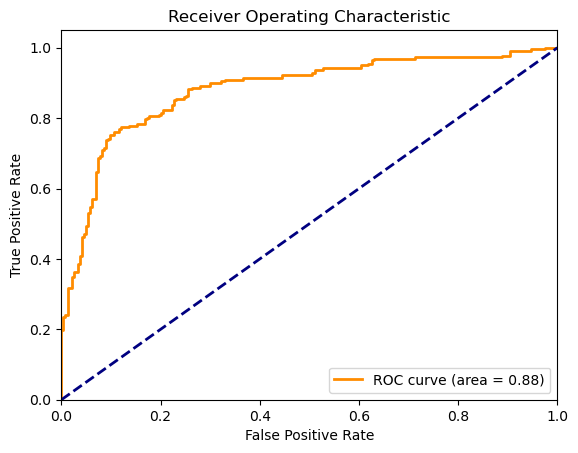

In [12]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

test_probabilities = model.predict([test_images, test_structured_data])

#ROC
fpr, tpr, thresholds = roc_curve(test_target, test_probabilities)

roc_auc = auc(fpr, tpr)

# Plot ROC 
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [13]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

test_probabilities = model.predict([test_images, test_structured_data])

test_predictions = np.where(test_probabilities > 0.5, 1, 0)

cm = confusion_matrix(test_target, test_predictions)
print("Confusion Matrix:")
print(cm)

cr = classification_report(test_target, test_predictions)
print("Classification Report:")
print(cr)


15/15 [==============================] - 8s 486ms/step
Confusion Matrix:
[[191  52]
 [ 39 182]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.79      0.81       243
           1       0.78      0.82      0.80       221

    accuracy                           0.80       464
   macro avg       0.80      0.80      0.80       464
weighted avg       0.81      0.80      0.80       464



In [16]:
# 모델 예측하기 0.5이상인 값들 은 암으로 그 이하는 암이 아닌걸로
y_pred_prob = model.predict([test_images, test_structured_data])
y_pred = [1 if prob > 0.5 else 0 for prob in y_pred_prob]

y_true = test_target

confusion = []
for i, j in zip(y_true, y_pred):
    if i == 0 and j == 0:
        confusion.append('실제로 암이 아니며, 예측도 암이 아님')
    elif i == 1 and j == 1:
        confusion.append('실제로 암이며, 예측도 암')
    elif i == 0 and j == 1:
        confusion.append('실제로 암이 아니지만, 예측은 암')
    else:
        confusion.append('실제로 암이지만, 예측은 암이 아님')

confusion_table = pd.DataFrame({'예측': y_pred,
                                '실제': y_true,
                                '결과': confusion})

confusion_counts = confusion_table['결과'].value_counts()

print(confusion_counts)

15/15 [==============================] - 8s 492ms/step
실제로 암이 아니며, 예측도 암이 아님    191
실제로 암이며, 예측도 암           182
실제로 암이 아니지만, 예측은 암        52
실제로 암이지만, 예측은 암이 아님       39
Name: 결과, dtype: int64
